# VAE

In [16]:
from model import VAE

import tensorflow as tf
import keras as K
import numpy as np
import os

### Data Preprocessing

In [17]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = tf.cast(mnist_digits, tf.float64) / 255.0
mnist_digits = np.expand_dims(mnist_digits, -1)

### Training the VAE

In [18]:
vae = VAE(image_size=28, channels=1, latent_dim=2)
vae.compile(optimizer=K.optimizers.Adam())
callbacks = vae.get_callbacks(log_dir="logs", patience=7)
vae.fit(mnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - kl_loss: 59.4412 - loss: 294.5778 - reconstruction_loss: 235.1366
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - kl_loss: 88.7486 - loss: 366.0893 - reconstruction_loss: 277.3409
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - kl_loss: 6.4876 - loss: 200.9063 - reconstruction_loss: 194.4187
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - kl_loss: 4.0382 - loss: 181.2826 - reconstruction_loss: 177.2444
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - kl_loss: 4.7394 - loss: 173.5782 - reconstruction_loss: 168.8388
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - kl_loss: 5.4438 - loss: 170.6420 - reconstruction_loss: 165.1981
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - kl_loss: 6.9640 - loss: 174.5603 - reconstruction_loss: 167.5962
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - kl_loss: 8.7333 - loss: 179.3515 - reconstruction_loss: 170.6182
Epoch 9/30
274/274 ━━━━━━━━━━━

In [19]:
for metric in vae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 184.68911743164062
reconstruction_loss: 178.30079650878906
kl_loss: 6.38834285736084


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [20]:
# Save
os.makedirs("./weights", exist_ok=True)
vae.encoder.save("./weights/encoder.keras")
vae.decoder.save("./weights/decoder.keras")

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


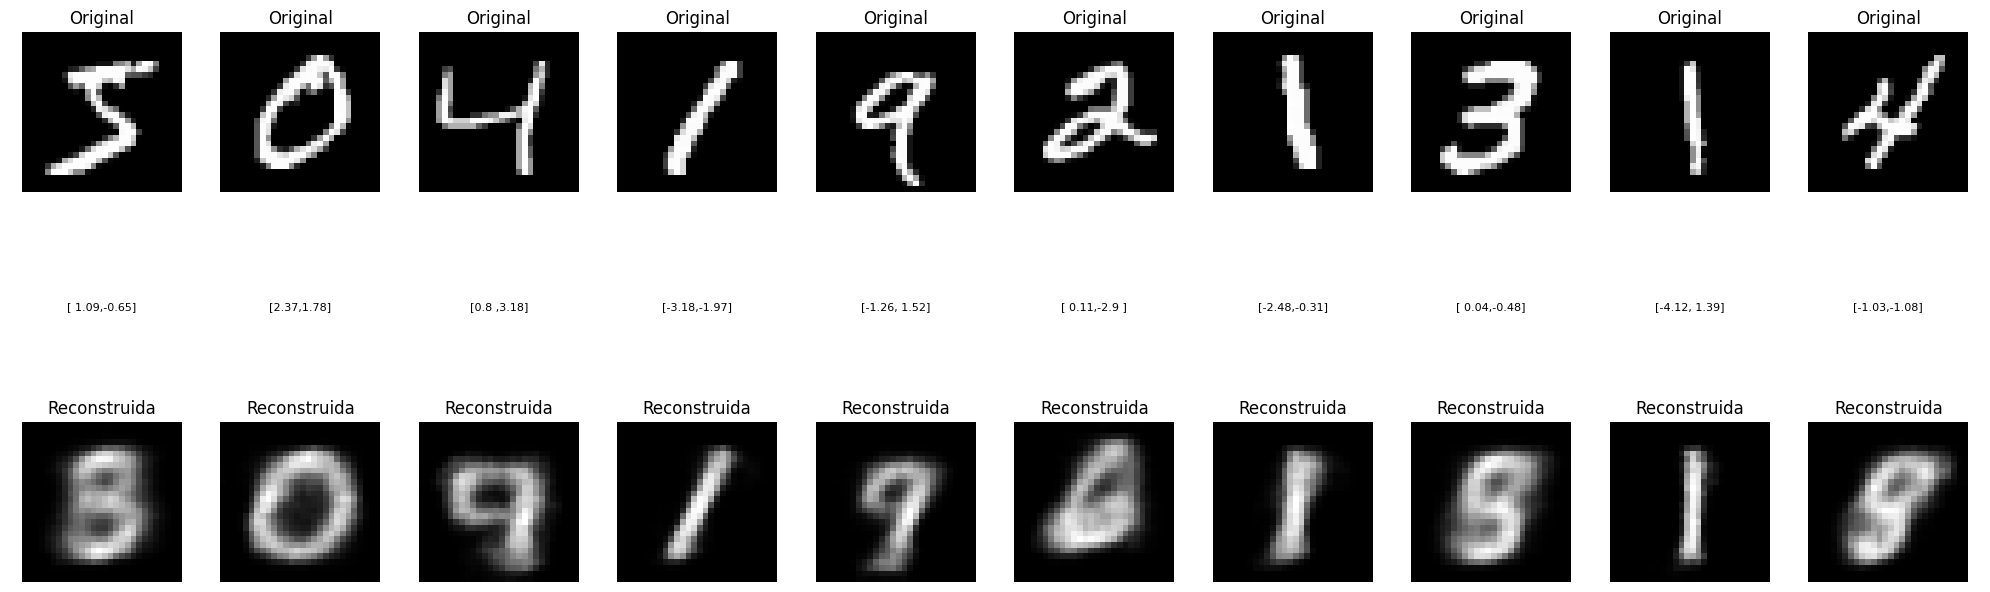

In [21]:
import matplotlib.pyplot as plt

n = 10
example_images = mnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae.encoder.predict(example_images)
predictions = vae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Fahion MNIST

In [22]:
(x_train, _), (x_test, _) = K.datasets.fashion_mnist.load_data()
fmnist_digits = np.concatenate([x_train, x_test], axis=0)
fmnist_digits = tf.cast(fmnist_digits, tf.float64) / 255.0
fmnist_digits = np.expand_dims(fmnist_digits, -1)

fvae = VAE(image_size=28, channels=1, latent_dim=32)
fvae.compile(optimizer=K.optimizers.Adam())
callbacks = fvae.get_callbacks(log_dir="logs", patience=7)
fvae.fit(fmnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - kl_loss: 12.2200 - loss: 322.2126 - reconstruction_loss: 309.9926
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - kl_loss: 16.3394 - loss: 262.3036 - reconstruction_loss: 245.9641
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - kl_loss: 16.9393 - loss: 256.5449 - reconstruction_loss: 239.6055
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - kl_loss: 17.8822 - loss: 254.5082 - reconstruction_loss: 236.6260
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - kl_loss: 19.1796 - loss: 254.4002 - reconstruction_loss: 235.2206
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - kl_loss: 22.1116 - loss: 258.4399 - reconstruction_loss: 236.3283
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - kl_loss: 24.2170 - loss: 262.6353 - reconstruction_loss: 238.4182
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - kl_loss: 39.3745 - loss: 303.1655 - reconstruction_loss: 263.7910
Epoch 9/30
274/274 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


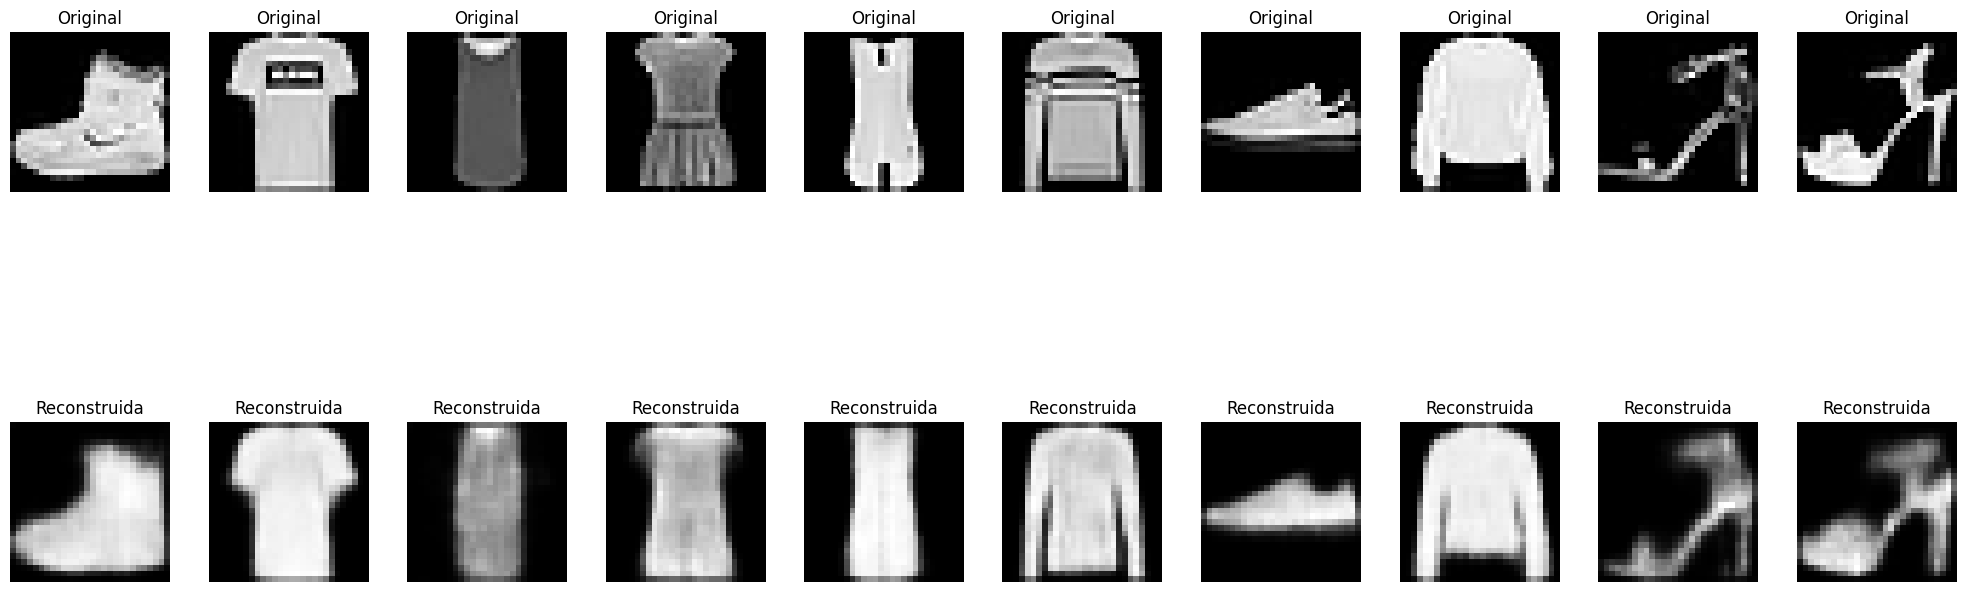

In [23]:
import matplotlib.pyplot as plt

n = 10
example_images = fmnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = fvae.encoder.predict(example_images)
predictions = fvae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    #ax = plt.subplot(3, n, i + 1 + n)
    #ax.axis("off")
    #z_text = np.array2string(z[i], precision=2, separator=",")
    #ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()

## CelebA Dataset

In [24]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

In [25]:
# Cargar splits de train y test
celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [26]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float64) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [27]:

vae2 = VAE(image_size=64, channels=3, latent_dim=256)

# Debemos reemplazar el decoder para que produzca imágenes de 64x64x3
latent_inputs = K.layers.Input(shape=(vae2.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 64x64
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae2 = VAE(image_size=64, channels=3, latent_dim=256, decoder=custom_decoder)
vae2.compile(optimizer=K.optimizers.Adam())
callbacks2 = vae2.get_callbacks(log_dir="logs", patience=3)
vae2.fit(celeb_a_train_batched, epochs=50, callbacks=callbacks2)

Epoch 1/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - kl_loss: 31.8973 - loss: 2360.8169 - reconstruction_loss: 2328.9207
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 73s 115ms/step - kl_loss: 32.2581 - loss: 2244.4260 - reconstruction_loss: 2212.1680
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 72s 113ms/step - kl_loss: 31.6579 - loss: 2223.3079 - reconstruction_loss: 2191.6509
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 68s 107ms/step - kl_loss: 32.6782 - loss: 2217.6167 - reconstruction_loss: 2184.9399
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 68s 107ms/step - kl_loss: 34.4827 - loss: 2211.0447 - reconstruction_loss: 2176.5620
Epoch 6/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 68s 106ms/step - kl_loss: 45.3172 - loss: 2227.9170 - reconstruction_loss: 2182.5994
Epoch 7/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 69s 109ms/step - kl_loss: 63.9888 - loss: 2262.7666 - reconstruction_loss: 2198.7771
Epoch 8/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step - kl_loss: 63.2306 - loss: 2258.7659 - reconstruction_loss: 2195.5359


In [28]:
for metric in vae2.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 2258.765869140625
reconstruction_loss: 2195.535888671875
kl_loss: 63.23061752319336


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


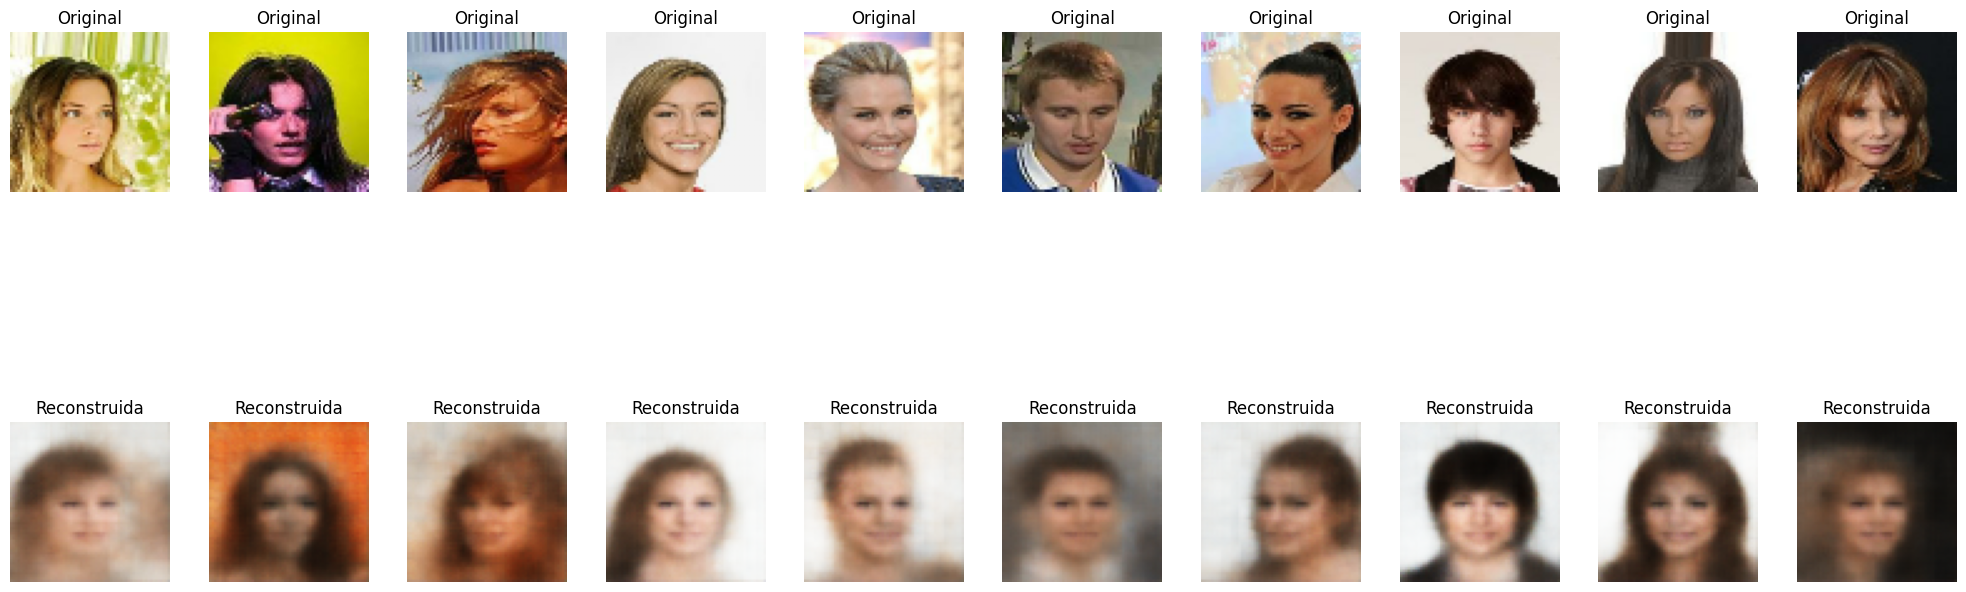

In [29]:
import matplotlib.pyplot as plt

n = 10
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae2.encoder.predict(images)
predictions = vae2.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].squeeze())
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze())
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


# CIFAR-10

In [33]:
(x_train, _), (x_test, _) = K.datasets.cifar10.load_data()
cifar_images = np.concatenate([x_train, x_test], axis=0)
cifar_images = tf.cast(cifar_images, tf.float64) / 255.0

In [34]:
vae3 = VAE(image_size=32, channels=3, latent_dim=256)

# Debemos reemplazar el decoder para que produzca imágenes de 32x32x3
latent_inputs = K.layers.Input(shape=(vae3.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)  # 32x32
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae3 = VAE(image_size=32, channels=3, latent_dim=256, decoder=custom_decoder)
vae3.compile(optimizer=K.optimizers.Adam())
callbacks3 = vae3.get_callbacks(log_dir="logs", patience=20)
vae3.fit(cifar_images, epochs=100, callbacks=callbacks3, batch_size=256)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - kl_loss: 4.7063 - loss: 675.0604 - reconstruction_loss: 670.3541
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - kl_loss: 8.5542 - loss: 654.6473 - reconstruction_loss: 646.0932
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - kl_loss: 9.5708 - loss: 647.9834 - reconstruction_loss: 638.4128
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - kl_loss: 9.9350 - loss: 640.8157 - reconstruction_loss: 630.8808
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - kl_loss: 10.3832 - loss: 637.7252 - reconstruction_loss: 627.3417
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - kl_loss: 11.1449 - loss: 638.2994 - reconstruction_loss: 627.1544
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - kl_loss: 11.7447 - loss: 637.2060 - reconstruction_loss: 625.4615
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - kl_loss: 12.2547 - loss: 637.0027 - reconstruction_loss: 624.7477
Epoch 9/100
235/235 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


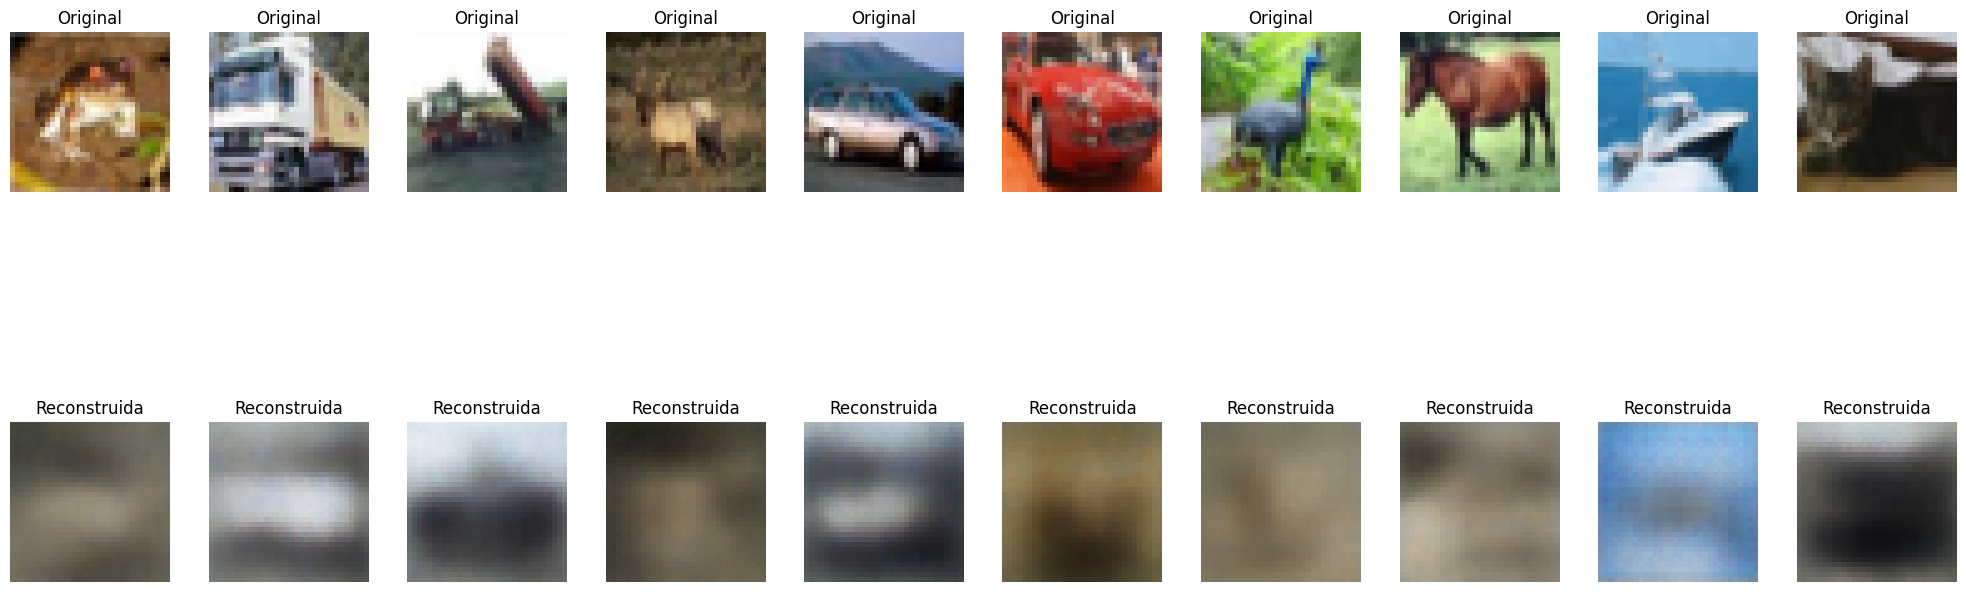

In [35]:
import matplotlib.pyplot as plt

n = 10
images = cifar_images[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae3.encoder.predict(images)
predictions = vae3.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i])
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
